In [18]:

#==============================================================================
# EJEMPLO DEL MÉTODO DE ANALISIS DE COMPONENETES PRINCIPALES
#==============================================================================

# Cargar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis # <--- LIBRERÍA AÑADIDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings

# Ignorar advertencias de convergencia para un reporte limpio
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Configuración visual de Seaborn
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 7)

### Se carga el dataset 
# Predict the Introverts from the Extroverts

### Este dataset contiene una colección de rasgos de comportamiento social y personalidad de diferentes individuos. Incluye 7 variables predictoras (como Time_spent_Alone, Stage_fear, Social_event_attendance, etc.) y una variable objetivo categórica, Personality.

### Su utilidad es para un problema de clasificación binaria: el objetivo es entrenar un modelo de machine learning (como Regresión Logística) que aprenda los patrones en las 7 variables de comportamiento para predecir si un individuo es "Introvertido" o "Extrovertido".

### Diccionario de Datos: Predicción de Personalidad

| Variable | Tipo | Descripción | Valores / Ejemplo |
| :--- | :--- | :--- | :--- |
| **id** | Numérica | 🆔 ID único para cada participante en la encuesta. | 0, 1, 2, ... |
| **Time\_spent\_Alone** | Numérica (Discreta) | ⏳ Horas promedio que la persona reporta pasar sola al día. | 0.0, 1.0, 6.0, ... |
| **Stage\_fear** | Categórica (Binaria) | 🎭 Indica si la persona reporta tener miedo escénico. | 'Yes', 'No' |
| **Social\_event\_attendance** | Numérica (Discreta) | 🥳 Frecuencia de asistencia a eventos sociales (escala/conteo). | 6.0, 7.0, 1.0, ... |
| **Going\_outside** | Numérica (Discreta) | 🏞️ Frecuencia con la que la persona reporta salir (escala/conteo). | 4.0, 3.0, 0.0, ... |
| **Drained\_after\_socializing**| Categórica (Binaria) | 🔋 Indica si la persona reporta sentirse agotada después de socializar. | 'Yes', 'No' |
| **Friends\_circle\_size** | Numérica (Discreta) | 👥 Tamaño reportado del círculo de amigos (escala/conteo). | 15.0, 10.0, 3.0, ... |
| **Post\_frequency** | Numérica (Discreta) | 📱 Frecuencia reportada de publicación en redes sociales (escala/conteo). | 5.0, 8.0, 0.0, ... |
| **Personality** | Categórica (Binaria) | 🎯 El rasgo de personalidad.<br>*Variable objetivo a predecir.* | 'Extrovert', 'Introvert' |


### Paso 1: Carga, Exploración y Limpieza de Datos

Cargamos los archivos del Dataset "Predicción de Personalidad" `train.csv` y `test.csv`realizamos la inspección inicial (nulos y duplicados).

In [2]:
df = pd.read_csv('./train.csv') # Cargar dataset
df_test=pd.read_csv('./test.csv')
df.head()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [3]:
# --- Conteo de Duplicados ---
duplicate_count = df.duplicated().sum()
print(f"\n--- Conteo de Duplicados ---")
print(f"Se encontraron {duplicate_count} filas duplicadas.")

# --- Limpieza de Duplicados ---
# Como Data Scientist, es crucial eliminar duplicados para un análisis estadístico válido.
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Duplicados eliminados. Nuevo shape: {df.shape}")


--- Conteo de Duplicados ---
Se encontraron 0 filas duplicadas.


In [4]:
# --- Análisis de la Variable Objetivo 'Class' ---
print("\n--- Análisis de la Variable Objetivo (Target) 'Personality' ---")
if 'Personality' in df.columns:
    num_classes = df['Personality'].nunique()
    print(f"Número de clases únicas (k): {num_classes}")
    print("\nDistribución de clases:")
    print(df['Personality'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
else:
    print("¡ERROR! No se encontró la columna 'Class', necesaria para LDA.")


--- Análisis de la Variable Objetivo (Target) 'Personality' ---
Número de clases únicas (k): 2

Distribución de clases:
Personality
Extrovert    73.95%
Introvert    26.05%
Name: proportion, dtype: object


In [5]:
# --- Análisis de la Variables tipo Object ---
print(df['Stage_fear'].unique())
print(df['Drained_after_socializing'].unique())

['No' 'Yes' nan]
['No' nan 'Yes']


In [6]:
# --- Transformamos las variables tipo Object a numerica usando Maping ---
mapping = {'Yes': 1, 'No': 0}
df['Stage_fear'] = df['Stage_fear'].map(mapping)

mapping1 = {'Yes': 1, 'No': 0}
df['Drained_after_socializing'] = df['Drained_after_socializing'].map(mapping1)

mapping2 = {'Extrovert': 1, 'Introvert': 0}
df['Personality'] = df['Personality'].map(mapping2)

df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,1
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,1
2,2,6.0,1.0,1.0,0.0,NaN,3.0,0.0,0
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,1
4,4,1.0,0.0,4.0,4.0,0.0,13.0,NaN,1


In [7]:
print(f"Dimensiones originales (filas, columnas): {df.shape}")
print("\n--- Inspección de Tipos y Nulos (df.info()) ---")
df.info()

Dimensiones originales (filas, columnas): (18524, 9)

--- Inspección de Tipos y Nulos (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  float64
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  float64
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.3 MB


In [8]:
# --- Imputacion de valores con KNN para los valores faltantes
num_cols = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing',
            'Friends_circle_size', 'Post_frequency']

imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [9]:
df.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

### Paso 2: Preprocesamiento de Datos para LDA

LDA es un método supervisado y tiene dos requisitos clave:
1.  **Características (X) escaladas:** LDA es sensible a la escala de las variables (como PCA), por lo que usaremos `StandardScaler`.
2.  **Variable Objetivo (y) numérica:** La variable `Class` es un objeto (texto), por lo que debemos codificarla a números (0, 1, 2...). Usaremos `LabelEncoder`.

In [11]:
# Definir X e y
# El dataset no contiene columnas 'y_ope' etc. Usaremos la columna disponible 'Personality' como objetivo.
target_variable = 'Personality'

# 'X' son todas las características: eliminamos 'id' y la variable objetivo
X = df.drop(['id', target_variable], axis=1)
y = df[target_variable]

print(f"\nForma de X (características): {X.shape}")
print(f"Forma de y (objetivo): {y.shape}")

# Codificar y (Variable Objetivo)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Clases en '{target_variable}': {class_names}")

# Las columnas numéricas ya fueron escaladas previamente en el flujo (KNNImputer + StandardScaler).
# Usamos directamente los valores de X para evitar doble escalado.
X_scaled = X.values
print("Se utilizaron los valores ya preprocesados en 'df' como X escalada.")


Forma de X (características): (18524, 7)
Forma de y (objetivo): (18524,)
Clases en 'Personality': [0 1]
Se utilizaron los valores ya preprocesados en 'df' como X escalada.


In [12]:
# k = 2 (No Enfermedad / Sí Enfermedad), por lo tanto n_components = 1
k = len(class_names)
n_components_lda = k - 1

print(f"Aplicando LDA. Reduciendo {X.shape[1]} características a {n_components_lda} componente...")

# Usamos scikit-learn
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)

# Ajustar (fit) y transformar (transform) los datos escalados (X) usando la info de 'y'
X_lda = lda.fit_transform(X_scaled, y_encoded)

print("Transformación LDA completada.")

# --- Varianza de Separación Explicada ---
explained_variance = lda.explained_variance_ratio_

print("\nVarianza de separación explicada por el Componente Discriminante (LD):")
print(f"  LD1: {explained_variance[0] * 100:.2f}%")

# --- Creación del DataFrame Transformado ---
df_lda = pd.DataFrame(data=X_lda, columns=['LD1'])
df_lda['Target'] = y.values # Añadir el objetivo original para colorear

Aplicando LDA. Reduciendo 7 características a 1 componente...
Transformación LDA completada.

Varianza de separación explicada por el Componente Discriminante (LD):
  LD1: 100.00%


Generando visualización de LD1...


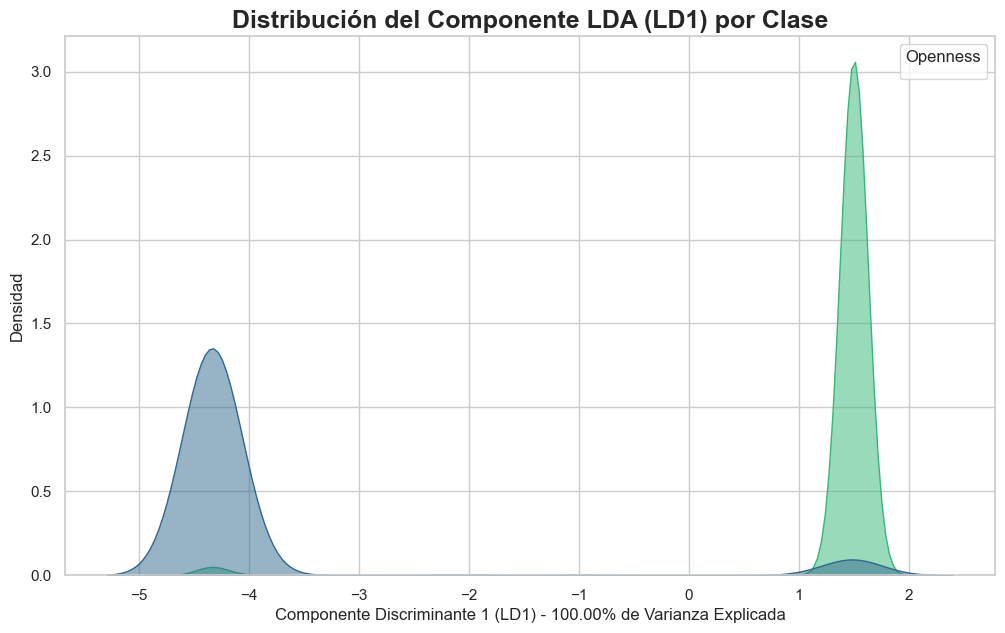

In [13]:
print("Generando visualización de LD1...")

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df_lda, x='LD1', hue='Target', fill=True, 
            common_norm=False, palette='viridis', alpha=0.5)

plt.title('Distribución del Componente LDA (LD1) por Clase', fontsize=18, weight='bold')
plt.xlabel(f'Componente Discriminante 1 (LD1) - {explained_variance[0] * 100:.2f}% de Varianza Explicada', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Openness')
plt.show()

### Paso 2: Preprocesamiento de Datos con PCA

PCA es un método supervisado y tieneutilidades clave:
1.  **Componentes principales:** Transforma las variables correlacionadas en un nuevo conjunto de variables que son matemáticamente no correlacionadas y resumen los patrones de los datos.
2.  **Reduccion de dimensionalidad:** creando un dataset más pequeño y denso (X_pca) que es más fácil de procesar para un modelo de clasificación y reduce el riesgo de sobreajuste.
3.  **Identificación de Características Dominantes:** Feature_importance identifica cuáles de las variables originales son las que más definen los patrones de comportamiento en tus datos. Esto te permite, por ejemplo, justificar la construcción de un modelo de clasificación mucho más simple utilizando solo las características más importantes en lugar de las 7

Aplicando PCA. Reduciendo 7 características...
Transformación PCA completada.
Se necesitaron 5 componentes para explicar el 95% de la varianza.


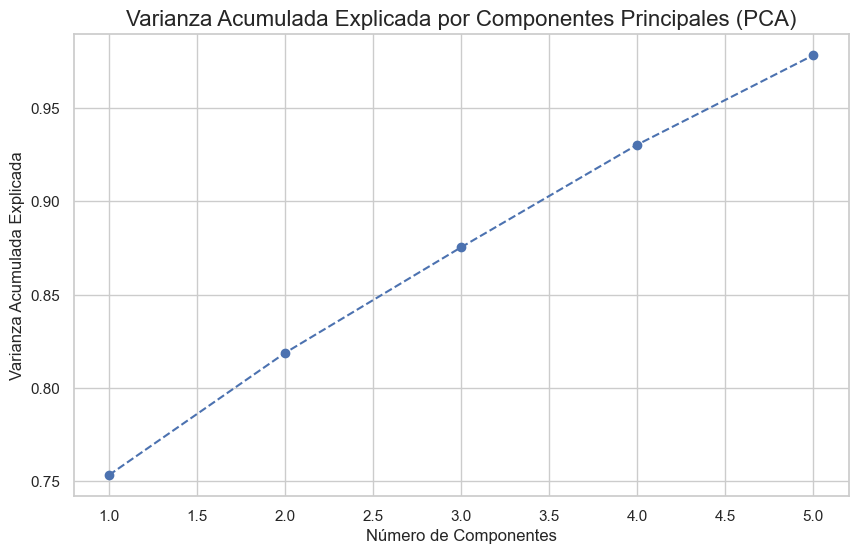

In [14]:
print(f"Aplicando PCA. Reduciendo {X.shape[1]} características...")

# Pedimos a PCA que encuentre el número de componentes que explican el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

n_components_pca = pca.n_components_
print(f"Transformación PCA completada.")
print(f"Se necesitaron {n_components_pca} componentes para explicar el 95% de la varianza.")

# --- Varianza Explicada Acumulada (Scree Plot) ---
explained_variance_pca = pca.explained_variance_ratio_
cumulative_variance_pca = np.cumsum(explained_variance_pca)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_pca + 1), cumulative_variance_pca, marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada por Componentes Principales (PCA)', fontsize=16)
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada Explicada', fontsize=12)
plt.grid(True)
plt.show()

# --- Creación del DataFrame Transformado ---
pca_columns = [f'PC{i+1}' for i in range(n_components_pca)]
df_pca = pd.DataFrame(data=X_pca, columns=pca_columns)
df_pca['Target'] = y.values # Añadir el objetivo original

Generando visualización de PC1 vs PC2...


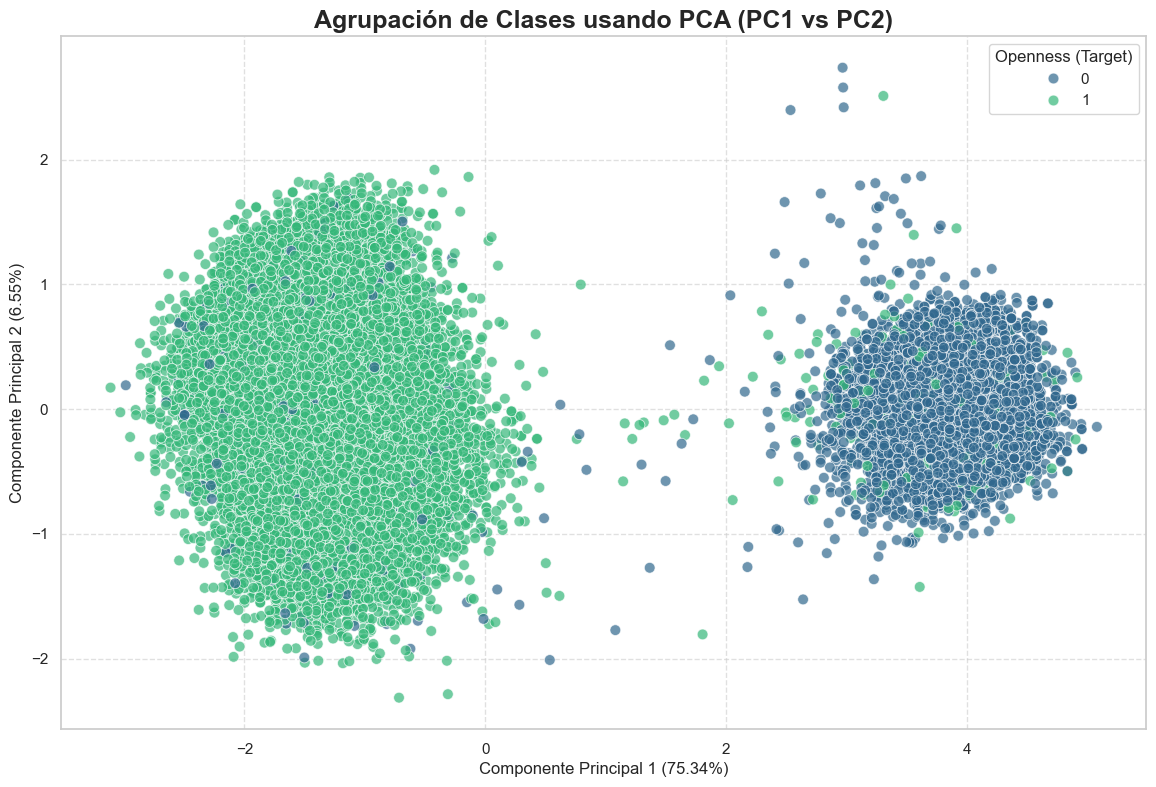

In [15]:
print("Generando visualización de PC1 vs PC2...")

# Calcular la varianza explicada solo por los dos primeros
variance_pc1_pc2 = np.sum(explained_variance_pca[:2]) * 100

plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='Target',  # Colorear por la clase
    s=60,
    alpha=0.7,
    palette='viridis'
)

plt.title(f'Agrupación de Clases usando PCA (PC1 vs PC2)', fontsize=18, weight='bold')
plt.xlabel(f'Componente Principal 1 ({explained_variance_pca[0] * 100:.2f}%)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({explained_variance_pca[1] * 100:.2f}%)', fontsize=12)
plt.legend(title='Openness (Target)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 5. Implementación de Análisis Factorial (FA)

A diferencia de PCA (que maximiza la varianza), el **Análisis Factorial (FA)** es un modelo de variable latente. Asume que las variables observadas (`X`) son combinaciones lineales de un número menor de "factores" subyacentes no observados.

En este caso, dado que el dataset se basa en el **modelo de personalidad "Big Five"**, tenemos un fuerte fundamento teórico para establecer el número de componentes en **5**. Usaremos una rotación `varimax` para mejorar la interpretabilidad de estos factores.

In [19]:
print(f"Aplicando Análisis Factorial (FA). Reduciendo {X.shape[1]} características a 5 factores...")

# 1. Definir el número de factores
# Nos basamos en la teoría del "Big Five" (OPE, CON, EXT, AGR, NEU)
n_factors = 5

# 2. Instanciar y ajustar el modelo
# Usamos rotación 'varimax' para que las cargas sean más interpretables
fa = FactorAnalysis(n_components=n_factors, 
                    rotation='varimax', 
                    random_state=42)

# Usamos los mismos datos escalados que PCA
X_fa = fa.fit_transform(X_scaled)

print("Transformación FA completada.")

# --- 3. Creación del DataFrame Transformado ---
fa_columns = [f'Factor_{i+1}' for i in range(n_factors)]
df_fa = pd.DataFrame(data=X_fa, columns=fa_columns)
df_fa['Target'] = y.values # Usamos el mismo 'y' (openness) de ejemplo

print("\n--- Muestra del DataFrame transformado (primeros 5) ---")
print(df_fa.head())

Aplicando Análisis Factorial (FA). Reduciendo 7 características a 5 factores...
Transformación FA completada.

--- Muestra del DataFrame transformado (primeros 5) ---
   Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Target
0 -0.555311  0.388661 -0.448921  0.205397 -0.241773       1
1 -0.562756  0.249019 -0.172213  0.305533  0.248472       1
2  1.570381 -0.445690 -0.142069  0.588662 -0.371047       0
3 -0.592657  0.356563  0.229848  0.360620 -0.094597       1
4 -0.623852 -0.002360 -0.211815  0.135712 -0.135544       1



--- Cargas Factoriales (Loadings) ---
                           Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
Time_spent_Alone           0.815460 -0.134246  0.212284  0.063741 -0.058875
Stage_fear                 0.965618 -0.198031  0.050681  0.116419 -0.087332
Social_event_attendance   -0.710414  0.321440 -0.049073 -0.096776  0.119491
Going_outside             -0.746330  0.143369 -0.048136 -0.267589  0.086422
Drained_after_socializing  0.965856 -0.194448  0.052296  0.118324 -0.089355


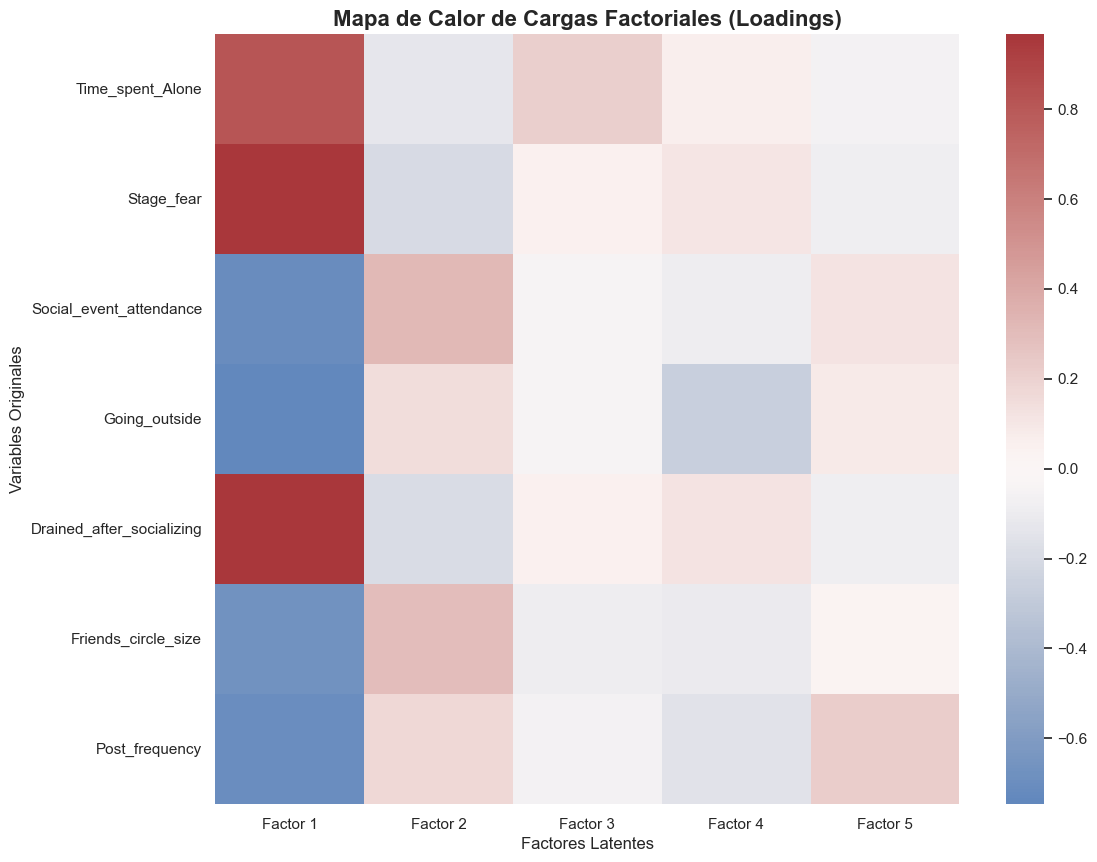

In [20]:
# Lo transponemos (.T) para que las características sean filas
df_loadings = pd.DataFrame(
    fa.components_.T, 
    columns=[f'Factor {i+1}' for i in range(n_factors)], 
    index=X.columns
)

print("\n--- Cargas Factoriales (Loadings) ---")
print(df_loadings.head())

# Visualizar las cargas en un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(
    df_loadings,
    cmap='vlag', # 'vlag' (Azul-Blanco-Rojo) es ideal para valores centrados en 0
    center=0,      # Centrar la barra de color en 0
    annot=False,   # 'False' porque 25x5 con números sería ilegible
    fmt=".2f"
)
plt.title('Mapa de Calor de Cargas Factoriales (Loadings)', fontsize=16, weight='bold')
plt.xlabel('Factores Latentes', fontsize=12)
plt.ylabel('Variables Originales', fontsize=12)
plt.show()

**Interpretación del Mapa de Calor:**
Este gráfico es clave. Debes buscar:
* **Rojo Fuerte:** Variables que cargan *positivamente* en un factor.
* **Azul Fuerte:** Variables que cargan *negativamente* en un factor.
* **Blanco/Casi Blanco:** Variables que no están relacionadas con ese factor.

Idealmente, cada factor estará fuertemente correlacionado (rojo/azul) con un grupo de variables que tengan sentido en conjunto (ej. Factor 1 podría agrupar todas las preguntas de `OPE`, Factor 2 todas las de `CON`, etc.).

#### Visualización de FA (Factor 1 vs Factor 2)

Finalmente, graficamos los dos primeros factores (que no necesariamente son los que más varianza explican, sino los dos primeros encontrados) para ver si agrupan las clases.

Generando visualización de Factor 1 vs Factor 2...


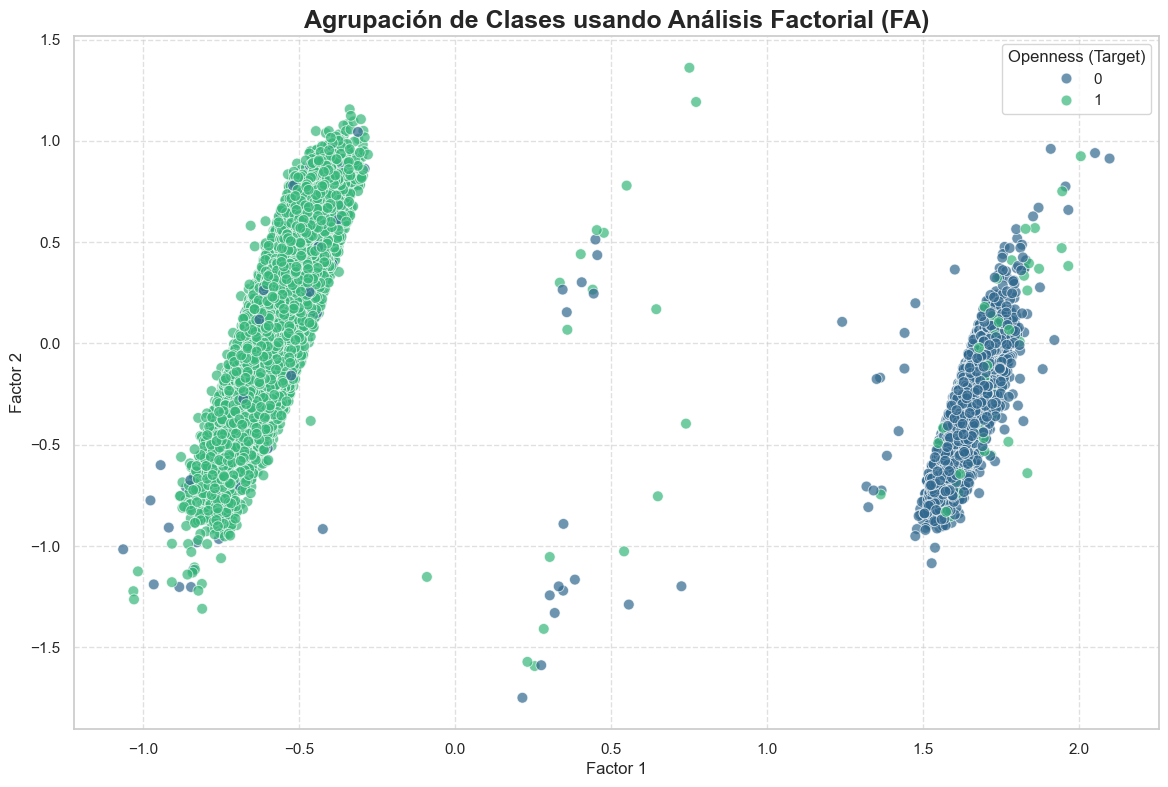

In [21]:
print("Generando visualización de Factor 1 vs Factor 2...")

plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=df_fa,
    x='Factor_1',
    y='Factor_2',
    hue='Target',  # Colorear por la clase 'openness'
    s=60,
    alpha=0.7,
    palette='viridis'
)

plt.title(f'Agrupación de Clases usando Análisis Factorial (FA)', fontsize=18, weight='bold')
plt.xlabel('Factor 1', fontsize=12)
plt.ylabel('Factor 2', fontsize=12)
plt.legend(title='Openness (Target)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Relevancia de la Regresión Logística Múltiple en este Problema

La implementación de una **Regresión Logística Múltiple** es el método estadístico fundamental para este problema de clasificación.

* **Objetivo (Clasificación Binaria):** Nuestro objetivo es predecir una variable categórica con solo dos resultados: "Introvertido" o "Extrovertido".
* **Por qué Logística (y no Lineal):** A diferencia de la regresión lineal (que predice un número), la regresión logística está diseñada específicamente para predecir la **probabilidad** (un valor entre 0 y 1) de que un individuo pertenezca a una de las clases.
* **Por qué "Múltiple":** Se denomina "Múltiple" porque utilizamos simultáneamente las **7 variables predictoras** (como `Time_spent_Alone`, `Stage_fear`, etc.) para calcular esa probabilidad.

Su relevancia radica en que no solo nos permite *clasificar* a los individuos, sino también *interpretar* el impacto de cada rasgo de comportamiento (cada variable) sobre la probabilidad de ser introvertido o extrovertido.

In [22]:
import statsmodels.api as sm
import numpy as np

# --- 1. Preparar los Datos ---
# Asumimos que 'X_fa' es el resultado de tu fa.fit_transform(X_scaled)
# Asumimos que 'y_encoded' es tu variable objetivo (ej. 'y_ope' codificada como 0 y 1)

# Para statsmodels, debemos añadir manualmente la constante (intercepto) a nuestros factores
X_fa_con_constante = sm.add_constant(X_fa, prepend=True)

# Verificamos la forma. Debería ser (n_observaciones, 6) -> 1 const + 5 Factores
print(f"Forma de los datos de entrada (X): {X_fa_con_constante.shape}")
print(f"Forma de los datos de salida (y): {y_encoded.shape}")


# --- 2. Ajustar el Modelo de Regresión Logística ---
# Usamos sm.Logit porque nuestro 'y' es binario (0 o 1)
logit_model_fa = sm.Logit(y_encoded, X_fa_con_constante)

# Entrenamos el modelo
result_fa = logit_model_fa.fit()


# --- 3. Mostrar los Resultados ---
# Imprimimos el resumen estadístico detallado
print("\n--- Resumen del Modelo de Regresión Logística sobre Factores Latentes ---")
print(result_fa.summary())

Forma de los datos de entrada (X): (18524, 6)
Forma de los datos de salida (y): (18524,)
Optimization terminated successfully.
         Current function value: 0.133611
         Iterations 8

--- Resumen del Modelo de Regresión Logística sobre Factores Latentes ---
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                18524
Model:                          Logit   Df Residuals:                    18518
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.7670
Time:                        14:05:38   Log-Likelihood:                -2475.0
converged:                       True   LL-Null:                       -10624.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------